In [51]:
import os
import json
import pickle
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import swifter

import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer

pd.set_option('display.max_colwidth', 128)
pd.set_option('display.max_columns', 500)

In [ ]:
https://github.com/jlko/semantic_uncertainty/blob/a8d9aa8cecd5f3bec09b19ae38ab13552e0846f4/semantic_uncertainty/uncertainty/models/huggingface_models.py

transition_scores = self.model.compute_transition_scores(
            outputs.sequences, outputs.scores, normalize_logits=True)
        # Transition_scores[0] only contains the scores for the first generated tokens.

        log_likelihoods = [score.item() for score in transition_scores[0]]
        if len(log_likelihoods) == 1:
            logging.warning('Taking first and only generation for log likelihood!')
            log_likelihoods = log_likelihoods
        else:
            log_likelihoods = log_likelihoods[:n_generated]

        if len(log_likelihoods) == self.max_new_tokens:
            logging.warning('Generation interrupted by max_token limit.')

        if len(log_likelihoods) == 0:
            raise ValueError

In [52]:
!ls -larth preprocess*

-rw-r--r--  1 bono  staff   1.3G Mar 12 11:49 preprocessed.pickle.old
-rw-r--r--  1 bono  staff   2.6G Mar 15 09:54 preprocessed.pickle


In [53]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
m = mydict['m']
answers = mydict['answers']

In [54]:
minrun = answers.run.max()
minrun

9

In [55]:
segments.groupby('pid').end.max().mean()

3331.779069767442

In [56]:
gen = segments[segments.segment=='generated']
gen['length'] = gen.end - gen.start

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/3135544532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen['length'] = gen.end - gen.start


In [57]:
gen.groupby('pid').length.max().mean()

25.953488372093023

In [58]:
# attach older data
if False:
    with open('preprocessed.pickle.old', 'rb') as handle:
        mydict = pickle.load(handle)

    truth_old = mydict['truth']
    segments_old = mydict['segments']
    m_old = mydict['m']
    answers_old = mydict['answers']

    # add virtual run
    truth_old.run = truth_old.run + minrun + 1
    segments_old.run = segments_old.run + minrun + 1
    m_old.run = m_old.run + minrun + 1
    answers_old.run = answers_old.run + minrun + 1

    # concat
    #truth = pd.concat([truth, truth_old])
    #segments = pd.concat([segments, segments_old])
    #m = pd.concat([m, m_old])
    #answers = pd.concat([answers, answers_old])

<Axes: xlabel='correct', ylabel='Count'>

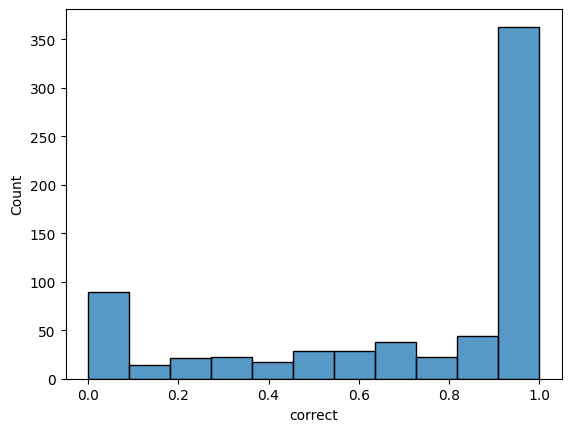

In [59]:
corec = truth.groupby('pid').correct.mean()
sns.histplot(corec, bins=corec.nunique())

In [60]:
model_name = "osunlp/TableLlama"
config = transformers.AutoConfig.from_pretrained(model_name)
orig_ctx_len = getattr(config, "max_position_embeddings", None)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=orig_ctx_len, padding_side="left", use_fast=False)

In [61]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [62]:
# load questions

file_path = "turl_test_2k_prompts_50.jsonl"

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [63]:
%%time

# tokenize inputs

tokenized = []

for idx, p in enumerate(prompts):
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt")
    p['pid'] = idx
    p['prompt'] = prompt
    p['tokenized'] = inputs
    tokenized.append(p)

Token indices sequence length is longer than the specified maximum sequence length for this model (4857 > 4096). Running this sequence through the model will result in indexing errors


CPU times: user 12.5 s, sys: 82.1 ms, total: 12.6 s
Wall time: 12.6 s


In [64]:
%%time

prompt_lenghts = []

for p in tokenized:
    plen = p['tokenized']['input_ids'][0].shape[0]
    
    cand_len = len(p['question'].split('>,')) - 1
    
    # TODO: check this! (some misalignment can occur)
    cand_pos = [idx for idx, cand in enumerate(p['question'].split('>,')) if p['output'] in cand + '>']
    
    # extract candidates
    candidates = p['question'].split(',. What')[0].split('<')[1:]
    candidates = [c.replace('>,', '').replace('>', '') for c in candidates]
    
    candidates_clean = [c.replace('[DESCRIPTION] ', '').replace('[DESC] ', '').replace('[TYPE] ', '').lower() for c in candidates]
    candidates_clean = [c for c in candidates_clean if c]
    
    candidates_clean_seq = [tokenizer(c, return_tensors="pt")['input_ids'].tolist()[0] for c in candidates_clean]
    
    prompt_lenghts.append((p['pid'], len(p['prompt']), plen, cand_len, cand_pos, candidates, candidates_clean, candidates_clean_seq))

pl = pd.DataFrame(prompt_lenghts, columns=['pid', 'char_len', 'tok_len', 'cand_len', 'cand_pos', 'cand', 'cand_clean', 'cand_clean_seq'])
pl['cand_pos_first'] = pl.cand_pos.str[0]

CPU times: user 7.31 s, sys: 76.5 ms, total: 7.38 s
Wall time: 7.38 s


In [65]:
pl

,pid,char_len,tok_len,cand_len,cand_pos,cand,cand_clean,cand_clean_seq,cand_pos_first
0,0,5932,2046,49,[25],"[Petaling Jaya City Council [DESC] None [TYPE] city council, Sekolah Kebangsaan Kelana Jaya [DESC] None [TYPE] national scho...","[petaling jaya city council none city council, sekolah kebangsaan kelana jaya none national school, template:kelana jaya lin...","[[1, 5697, 12818, 432, 9010, 4272, 18701, 5642, 4272, 18701], [1, 409, 10028, 801, 413, 774, 574, 4977, 273, 413, 295, 1648,...",25
1,1,6254,1960,50,[7],"[flag of Eritrea [DESC] flag [TYPE] national flag, Category:Eritrea stubs [DESC] Wikimedia category [TYPE] Wikimedia categor...","[flag of eritrea flag national flag, category:eritrea stubs wikimedia category wikimedia category of stubs, escaping eritrea...","[[1, 7353, 310, 604, 277, 5638, 7353, 4797, 7353], [1, 7663, 29901, 261, 277, 5638, 19281, 29879, 281, 638, 3393, 7663, 281,...",7
2,2,7084,2341,49,[22],[David R. Macdonald Papers (NAID 649130) [DESC] collection in the National Archives and Records Administration's holdings [T...,[david r. macdonald papers (naid 649130) collection in the national archives and records administration's holdings collectio...,"[[1, 13260, 333, 364, 29889, 5825, 9176, 2741, 15055, 313, 1056, 333, 29871, 29953, 29946, 29929, 29896, 29941, 29900, 29897...",22
3,3,8322,2801,49,[16],"[3218 Delphine [DESC] asteroid [TYPE] asteroid, Antonio Delfino [DESC] Wikimedia list article [TYPE] cargo liner, Inés María...","[3218 delphine asteroid asteroid, antonio delfino wikimedia list article cargo liner, inés maría female given name female gi...","[[1, 29871, 29941, 29906, 29896, 29947, 628, 561, 457, 20058, 333, 20058, 333], [1, 385, 880, 601, 628, 29888, 1789, 281, 63...",16
4,4,5771,1931,49,[25],"[Cleaning Pots [DESC] painting by Louis Mettling [TYPE] painting, Josie's Pots [DESC] episode of Teletubbies [TYPE] televisi...","[cleaning pots painting by louis mettling painting, josie's pots episode of teletubbies television series episode, pots nove...","[[1, 5941, 292, 282, 1862, 20413, 491, 301, 283, 275, 1539, 29873, 1847, 20413], [1, 432, 359, 347, 29915, 29879, 282, 1862,...",25
...,...,...,...,...,...,...,...,...,...
1796,1796,11211,4548,50,[12],"[, 2nd edition [DESC] None [TYPE] scholarly article, Charis [DESC] given name [TYPE] unisex given name, Hyas [DESC] mythical...","[, 2nd edition none scholarly article, charis given name unisex given name, hyas mythical character mythological greek chara...","[[1, 1919, 29871, 29906, 299, 12203, 5642, 21344, 368, 4274], [1, 1373, 275, 2183, 1024, 443, 275, 735, 2183, 1024], [1, 749...",12
1797,1797,19596,5464,52,[21],"[A Manual of the Climate and Diseases of Tropical Countries; in Which a Practical View of the Statistical Pathology, and of ...","[a manual of the climate and diseases of tropical countries; in which a practical view of the statistical pathology, and of ...","[[1, 263, 12219, 310, 278, 23622, 322, 10267, 2129, 310, 21881, 10916, 29936, 297, 607, 263, 15031, 1776, 310, 278, 24148, 2...",21
1798,1798,11557,2907,50,[8],"[Glacier Park International Airport [DESC] regional airport in Kalispell, Montana [TYPE] airport, Nursultan Nazarbayev Inter...","[glacier park international airport regional airport in kalispell, montana airport, nursultan nazarbayev international airpo...","[[1, 14751, 13241, 14089, 6121, 4799, 637, 14014, 4799, 637, 297, 413, 5711, 29886, 514, 29892, 7629, 1648, 4799, 637], [1, ...",8
1799,1799,10639,2717,49,[47],"[Southfield [DESC] suburb of Cape Town, South Africa [TYPE] neighborhood, City of Cape Town [DESC] metropolitan municipality...","[southfield suburb of cape town, south africa neighborhood, city of cape town metropolitan municipality in western cape, sou...","[[1, 7062, 2671, 1014, 9265, 310, 274, 4085, 4726, 29892, 7062, 263, 18961, 18403], [1, 4272, 310, 274, 4085, 4726, 25311, 8...",47


In [66]:
pl.cand_len

0       49
1       50
2       49
3       49
4       49
        ..
1796    50
1797    52
1798    50
1799    49
1800    49
Name: cand_len, Length: 1801, dtype: int64

In [67]:
deb_ = pl.cand.str.len() == pl.cand_clean.str.len()


In [68]:
a = answers.merge(pl, on='pid', how='left')
a['reconstructed'] = a.apply(lambda row: row['cand'][row['cand_pos_first']], axis=1)

a['reconstructed_correct'] = (a.answer.str.replace('[DESCRIPTION]', '[DESC]').str.lower() == a.reconstructed.str.lower())
a['correct'] = (a.answer.str.replace('[DESCRIPTION]', '[DESC]').str.lower() == a.right_answer.str.replace('<', '').str.replace('>', '').str.lower())


In [69]:
a.shape

(6880, 16)

In [70]:
deb = a.merge(truth, on=['run', 'pid'])
deb['cand_present'] = deb.apply(lambda row: any([el.lower() == row['answer'].lower() for el in row['cand_clean']]), axis=1)

In [71]:
# TODO debug di questi casi residuali in cui la ricostruzione del candidato non coincide con 'truth' importato
# (validato in tablellama-plot)

# x è la ricostruzione, y è nella for the rigenera tutto (truth)
deb[(deb.reconstructed_correct != deb.correct_y)]

,run,pid,answer,answer_seq,right_answer,char_len,tok_len,cand_len,cand_pos,cand,cand_clean,cand_clean_seq,cand_pos_first,reconstructed,reconstructed_correct,correct_x,correct_y,hallucinated,cand_present
44,0,38,Karan Ashley [DESC] American actress [TYPE] Television actor,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<karan ashley [desc] american actress [type] television actor>,16227,5596,50,[8],"[B 12 , C 12 , and the Red Giants [DESC] scientific article [TYPE] scholarly article, Ancient Roman Statutes...","[b 12 , c 12 , and the red giants scientific article scholarly article, ancient roman statutes: a translatio...","[[1, 289, 1678, 29896, 29906, 268, 1919, 268, 274, 1678, 29896, 29906, 268, 1919, 322, 278, 2654, 4005, 1934, 16021, 4274, 2...",8,"lk refid=""m4.10"" [DESC] article [TYPE] scholarly article",False,True,True,False,False
45,1,38,Karan Ashley [DESC] American actress [TYPE] Television actor,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<karan ashley [desc] american actress [type] television actor>,16227,5596,50,[8],"[B 12 , C 12 , and the Red Giants [DESC] scientific article [TYPE] scholarly article, Ancient Roman Statutes...","[b 12 , c 12 , and the red giants scientific article scholarly article, ancient roman statutes: a translatio...","[[1, 289, 1678, 29896, 29906, 268, 1919, 268, 274, 1678, 29896, 29906, 268, 1919, 322, 278, 2654, 4005, 1934, 16021, 4274, 2...",8,"lk refid=""m4.10"" [DESC] article [TYPE] scholarly article",False,True,True,False,False
46,2,38,Karan Ashley [DESC] American actress [TYPE] Television actor,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<karan ashley [desc] american actress [type] television actor>,16227,5596,50,[8],"[B 12 , C 12 , and the Red Giants [DESC] scientific article [TYPE] scholarly article, Ancient Roman Statutes...","[b 12 , c 12 , and the red giants scientific article scholarly article, ancient roman statutes: a translatio...","[[1, 289, 1678, 29896, 29906, 268, 1919, 268, 274, 1678, 29896, 29906, 268, 1919, 322, 278, 2654, 4005, 1934, 16021, 4274, 2...",8,"lk refid=""m4.10"" [DESC] article [TYPE] scholarly article",False,True,True,False,False
47,3,38,Karan Ashley [DESC] American actress [TYPE] Television actor,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<karan ashley [desc] american actress [type] television actor>,16227,5596,50,[8],"[B 12 , C 12 , and the Red Giants [DESC] scientific article [TYPE] scholarly article, Ancient Roman Statutes...","[b 12 , c 12 , and the red giants scientific article scholarly article, ancient roman statutes: a translatio...","[[1, 289, 1678, 29896, 29906, 268, 1919, 268, 274, 1678, 29896, 29906, 268, 1919, 322, 278, 2654, 4005, 1934, 16021, 4274, 2...",8,"lk refid=""m4.10"" [DESC] article [TYPE] scholarly article",False,True,True,False,False
312,0,217,Patrick Eaves [DESC] Canadian born-American ice hockey player [TYPE] ice hockey player,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<patrick eaves [desc] canadian born-american ice hockey player [type] ice hockey player>,7007,1939,49,[33],"[Thackit Eaves [DESC] architectural structure in Northill, Central Bedfordshire, Bedfordshire, UK [TYPE] thatched cottage, T...","[thackit eaves architectural structure in northill, central bedfordshire, bedfordshire, uk thatched cottage, the eaves archi...","[[1, 266, 547, 277, 321, 5989, 6956, 3631, 3829, 297, 6641, 453, 29892, 6555, 6592, 4006, 11750, 29892, 6592, 4006, 11750, 2...",33,"Boston Baptist College [DESC] Baptist bible college in Milton, Massachusetts [TYPE] private not-for-profit educational insti...",False,True,True,False,Fa

In [72]:
deb_[deb_==False]

38      False
108     False
158     False
222     False
505     False
588     False
1006    False
1119    False
1252    False
1302    False
1545    False
1606    False
1719    False
1768    False
1770    False
dtype: bool

In [73]:
# TODO alcuni sono dovuti a disallineamento della lista cand_len (omissione durante pulizia!)
deb[(deb.reconstructed_correct != deb.correct_y)].pid.unique()

array([  38,  217,  338, 1302, 1768, 1770, 1797])

In [74]:
mypid = 217
candlist = deb[deb.pid==mypid].drop_duplicates('pid').iloc[0].cand
candlist_clean = deb[deb.pid==mypid].drop_duplicates('pid').iloc[0].cand_clean

len(candlist), len(candlist_clean)

(50, 50)

In [76]:
deb[(deb.correct_x != deb.correct_y)][['answer', 'reconstructed', 'right_answer', 'correct_x', 'correct_y']]

,answer,reconstructed,right_answer,correct_x,correct_y


In [77]:
# allucinazioni
deb[(~deb.cand_present) & (deb.hallucinated)]

,run,pid,answer,answer_seq,right_answer,char_len,tok_len,cand_len,cand_pos,cand,cand_clean,cand_clean_seq,cand_pos_first,reconstructed,reconstructed_correct,correct_x,correct_y,hallucinated,cand_present
320,0,221,23rd Goya Awards [DESC] award ceremony for Spanish films of 2008 [TYPE] Goya Award ceremony,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<23rd goya awards [desc] award ceremony for spanish films of 2008 [type] goya awards ceremony>,7922,2992,50,[5],"[Biathlon Junior World Championships 2008 [DESC] world championship [TYPE] sports season, 2008 [DESC] natural number [TYPE] ...","[biathlon junior world championships 2008 world championship sports season, 2008 natural number even number, defects 2008 no...","[[1, 4768, 493, 12957, 20183, 3186, 8064, 9981, 29871, 29906, 29900, 29900, 29947, 3186, 22401, 14717, 4259], [1, 29871, 299...",5,23rd Goya Awards [DESC] award ceremony for Spanish films of 2008 [TYPE] Goya Awards ceremony,False,False,False,True,False
322,2,221,23rd Goya Awards [DESC] award ceremony for Spanish films of 2008 [TYPE] Goya Award ceremony,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<23rd goya awards [desc] award ceremony for spanish films of 2008 [type] goya awards ceremony>,7922,2992,50,[5],"[Biathlon Junior World Championships 2008 [DESC] world championship [TYPE] sports season, 2008 [DESC] natural number [TYPE] ...","[biathlon junior world championships 2008 world championship sports season, 2008 natural number even number, defects 2008 no...","[[1, 4768, 493, 12957, 20183, 3186, 8064, 9981, 29871, 29906, 29900, 29900, 29947, 3186, 22401, 14717, 4259], [1, 29871, 299...",5,23rd Goya Awards [DESC] award ceremony for Spanish films of 2008 [TYPE] Goya Awards ceremony,False,False,False,True,False
323,3,221,23rd Goya Awards [DESC] award ceremony for Spanish films of 2008 [TYPE] Goya Award ceremony,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<23rd goya awards [desc] award ceremony for spanish films of 2008 [type] goya awards ceremony>,7922,2992,50,[5],"[Biathlon Junior World Championships 2008 [DESC] world championship [TYPE] sports season, 2008 [DESC] natural number [TYPE] ...","[biathlon junior world championships 2008 world championship sports season, 2008 natural number even number, defects 2008 no...","[[1, 4768, 493, 12957, 20183, 3186, 8064, 9981, 29871, 29906, 29900, 29900, 29947, 3186, 22401, 14717, 4259], [1, 29871, 299...",5,23rd Goya Awards [DESC] award ceremony for Spanish films of 2008 [TYPE] Goya Awards ceremony,False,False,False,True,False
329,1,229,Union of Democratic Forces [DESC] political party in Bulgaria [TYPE] political party,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<union of democratic forces [desc] political party [type] political party in bulgaria>,10142,2972,50,[15],"[National Democratic Union [DESC] political party in Armenia [TYPE] political party, Union of Democratic Forces of Guinea [D...","[national democratic union political party in armenia political party, union of democratic forces of guinea political party ...","[[1, 4797, 1261, 8415, 2454, 9833, 8604, 6263, 297, 564, 1527, 423, 8604, 6263], [1, 9833, 310, 1261, 8415, 2454, 8249, 310,...",15,Union of Democratic Forces [DESC] political party [TYPE] political party in Bulgaria,False,False,False,True,False
331,3,229,Union of Democratic Forces [DESC] political party in Bulgaria [TYPE] political party,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<union of democratic forces [desc] political party [type] political party in bulgaria>,10142,2972,50,[15],"[National Democratic Union [DESC] political party in 

In [78]:
def cleanup_before_she_comes(mystr):
    mystr = mystr.replace('[DESC] ', '').replace('[DESCRIPTION] ', '').replace('[TYPE] ', '')
    # if ']' in mystr or '[' in mystr: print(mystr)
    return mystr

a['answer_clean'] = a.answer.apply(lambda x: cleanup_before_she_comes(x)).str.lower()
a['right_answer_clean'] = a['right_answer'].str.replace('[description] ', '').str.replace('[desc] ', '').str.replace('[type] ', '').str.replace('<', '').str.replace('>', '')


### distance among correct candidate and all candidates

In [79]:
from sentence_transformers import SentenceTransformer

device = torch.device("mps")
model = SentenceTransformer("all-mpnet-base-v2").to(device)


In [80]:
%%time

# do not compute the same embeddings many times
mycache = {}
myanscache = {}

if True:
    cc_ = []
    allc_ = []
    ans_ = []

    for row in a.itertuples():
        print(row.run, row.pid, end='\r')
        cc = row.right_answer_clean
        allc = row.cand_clean

        allc_tuple = tuple(allc)
        if (cc, allc_tuple) in mycache:
            (cc_embeddings, allc_embeddings) = mycache[(cc, allc_tuple)]
        else:
            cc_embeddings = model.encode([cc])
            allc_embeddings = model.encode(allc)
            mycache[(cc, allc_tuple)] = (cc_embeddings, allc_embeddings)    
        cc_.append(cc_embeddings)
        allc_.append(allc_embeddings)
            
        ans = row.answer_clean    
        if ans in myanscache:
            ans_embeddings = myanscache[ans]
        else:
            ans_embeddings = model.encode([ans])
            myanscache[ans] = ans_embeddings 
        ans_.append(ans_embeddings)
        

    a['right_answer_clean_embedding'] = cc_
    a['cand_clean_embedding'] = allc_
    a['answer_clean_embedding'] = ans_
    
    import pickle
    with open('cohesion.pickle', 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 2min 15s, sys: 21.4 s, total: 2min 37s
Wall time: 1min 45s


In [81]:
with open('cohesion.pickle', 'rb') as handle:
        a = pickle.load(handle)

In [82]:
a.shape, a[a.cand_len>=10].shape

((6880, 21), (6670, 21))

In [83]:
a.shape, a[a.cand_len>=10].shape

((6880, 21), (6670, 21))

In [84]:
# at least 10 candidates
a = a[a.cand_len>=10]

In [85]:
%%time

# extract cosine similarities among right candidate and all candidates (cold measure)
from sentence_transformers.util import cos_sim
a['cos_sim_right_cand'] = a.apply(lambda x: cos_sim(x['right_answer_clean_embedding'], x['cand_clean_embedding']), axis=1)

CPU times: user 4.15 s, sys: 1.53 s, total: 5.68 s
Wall time: 931 ms


In [86]:
# tensor to list
a['cos_sim_right_cand'] = a.apply(lambda x: x['cos_sim_right_cand'].tolist()[0], axis=1)

In [87]:
# check max sim is always self
a['cos_sim_right_cand'].apply(lambda x: max(x))

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
6875    1.0
6876    1.0
6877    1.0
6878    1.0
6879    1.0
Name: cos_sim_right_cand, Length: 6670, dtype: float64

In [88]:
# min candidates
a.apply(lambda x: len(x.cos_sim_right_cand), axis=1).min()

10

In [89]:
a.loc[0]['cand_clean_embedding'].shape

(49, 768)

In [90]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

def cosine_distance_stats(embeddings):
    D = pairwise_distances(embeddings, metric="cosine")
    triu_indices = np.triu_indices_from(D, k=1)  # upper triangular indices without diagonal
    distances = D[triu_indices]
    return (np.mean(distances), np.min(distances), np.max(distances), np.var(distances))

# gini ~ 0 -> uniform distances -> high cohesion
# gini ~ 1 -> variable distances -> low cohesion
def gini_coefficient(embeddings):
    D = pairwise_distances(embeddings, metric="cosine")
    triu_indices = np.triu_indices_from(D, k=1)  # upper triangular indices without diagonal
    distances = np.sort(D[triu_indices])  # sort
    n = len(distances)
    if n == 0:
        return 0
    index = np.arange(1, n + 1)  # index array
    return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index

import scipy.spatial
import scipy.linalg

def spectral_gap(embeddings):   
    try:
        # spectral gap (λ2) of the graph Laplacian from a distance matrix
        D = pairwise_distances(embeddings, metric="cosine")

        # distances to similarities
        sigma = np.median(D)  # scale
        W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix

        # Laplacian
        D_matrix = np.diag(W.sum(axis=1))
        L = D_matrix - W  # graph laplacian

        # eigenvalues
        eigenvalues = np.linalg.eigvalsh(L)
        return np.sort(eigenvalues)[1]  # second smallest eigenvalue is the spectral gap
    except Exception as e:
        return None

In [91]:
import numpy as np
import itertools

def jaccard_similarity(list1, list2):
    intersection = len(set(list1) & set(list2))
    union = len(set(list1)) + len(set(list2)) - intersection
    return float(intersection) / union if union != 0 else 0.0

def jaccard_upper_triangle(lists):
    n = len(lists)
    distances = []
    
    for i, j in itertools.combinations(range(n), 2):
        similarity = jaccard_similarity(lists[i], lists[j])
        distances.append(1 - similarity)

    return distances

def jaccard_distance_stats(mylist):
    if type(mylist[0]) == str: mylist = [l.split(' ') for l in mylist] # convert to list if string
    distances = jaccard_upper_triangle(mylist)
    return (np.mean(distances), np.min(distances), np.max(distances), np.var(distances))


In [92]:
%%time

# measures of consistency among candidates (also considering the right one)
# these measures are constant across runs (and can be used as input features)

# VRO w.r.t. correct answer 
a['right_cand_avg_dist'] = a.swifter.apply(lambda x: 1. - (sum(x.cos_sim_right_cand) - 1.) / (len(x.cos_sim_right_cand) - 1), axis=1)

# distance from the nearest
a['right_cand_mindist'] = a.swifter.apply(lambda x: 1. - x.cos_sim_right_cand[np.argpartition(x.cos_sim_right_cand, -2)[-2]], axis=1) # second largest distance

# distance matrix stats
a[['cand_average_dist','cand_min_dist','cand_max_dist','cand_variance_of_dist']] = a.swifter.apply(lambda x: cosine_distance_stats(x.cand_clean_embedding), axis=1, result_type='expand') 

# jaccard on words and tokens
a[['cand_average_jaccard_dist','cand_min_jaccard_dist','cand_max_jaccard_dist','cand_variance_of_jaccard_dist']] = a.swifter.apply(lambda x: jaccard_distance_stats(x.cand_clean), axis=1, result_type='expand') 
a[['cand_average_jaccard_tok_dist','cand_min_jaccard_tok_dist','cand_max_jaccard_tok_dist','cand_variance_of_jaccard_tok_dist']] = a.swifter.apply(lambda x: jaccard_distance_stats(x.cand_clean_seq), axis=1, result_type='expand') 

# gini coefficient
a['cand_gini_coef'] = a.swifter.apply(lambda x: gini_coefficient(x.cand_clean_embedding), axis=1) # gini coefficient

# spectral gap
a['cand_spectral_gap'] = a.swifter.apply(lambda x: spectral_gap(x.cand_clean_embedding), axis=1) # spectral gap


Pandas Apply:   0%|          | 0/6670 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6670 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6670 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6670 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6670 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6670 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6670 [00:00<?, ?it/s]

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:32: RuntimeWarning: divide by zero encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:32: RuntimeWarning: divide by zero encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:32: RuntimeWarning: divide by zero encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n

CPU times: user 45.9 s, sys: 40.7 s, total: 1min 26s
Wall time: 38 s


In [93]:
# TODO debug these mofos (most probably broken candidates lists)
a[a['cand_spectral_gap'].isna()]

,run,pid,answer,answer_seq,right_answer,char_len,tok_len,cand_len,cand_pos,cand,cand_clean,cand_clean_seq,cand_pos_first,reconstructed,reconstructed_correct,correct,answer_clean,right_answer_clean,right_answer_clean_embedding,cand_clean_embedding,answer_clean_embedding,cos_sim_right_cand,right_cand_avg_dist,right_cand_mindist,cand_average_dist,cand_min_dist,cand_max_dist,cand_variance_of_dist,cand_average_jaccard_dist,cand_min_jaccard_dist,cand_max_jaccard_dist,cand_variance_of_jaccard_dist,cand_average_jaccard_tok_dist,cand_min_jaccard_tok_dist,cand_max_jaccard_tok_dist,cand_variance_of_jaccard_tok_dist,cand_gini_coef,cand_spectral_gap
2012,0,1337,2002 Asian Games [DESC] 14th edition of the Asian Games [TYPE] multi-sport event,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<2002 asian games [desc] 14th edition of the asian games [type] multi-sport event>,3277,1280,50,[14],"[XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DE...","[xiv none none, xiv none none, xiv none none, xiv none none, xiv none none, xiv none none, xiv none none, xiv none none, xiv...","[[1, 921, 440, 5642, 5642], [1, 921, 440, 5642, 5642], [1, 921, 440, 5642, 5642], [1, 921, 440, 5642, 5642], [1, 921, 440, 5...",14,2002 Asian Games [DESC] 14th edition of the Asian Games [TYPE] multi-sport event,True,True,2002 asian games 14th edition of the asian games multi-sport event,2002 asian games 14th edition of the asian games multi-sport event,"[[-0.012658077, -0.07410771, -0.028125927, 0.06488383, 0.025158832, -0.039030988, 0.022237053, -0.008062955, 0.008687334, 0....","[[-0.019305073, 0.011741126, -0.018797569, 0.026917731, -0.03515655, -0.0023215783, -0.023435038, -0.0076800887, 0.027973024...","[[-0.012658077, -0.07410771, -0.028125927, 0.06488383, 0.025158832, -0.039030988, 0.022237053, -0.008062955, 0.008687334, 0....","[0.10867233574390411, 0.10867233574390411, 0.10867233574390411, 0.10867233574390411, 0.10867233574390411, 0.1086723357439041...",0.891328,0.891328,0.035653,0.0,0.891328,0.030507,0.04,0.0,1.0,0.0384,0.038095,0.0,0.952381,0.03483,0.96,NaN
2013,1,1337,2002 Asian Games [DESC] 14th edition of the Asian Games [TYPE] multi-sport event,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<2002 asian games [desc] 14th edition of the asian games [type] multi-sport event>,3277,1280,50,[14],"[XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DE...","[xiv none none, xiv none none, xiv none none, xiv none none, xiv none none, xiv none none, xiv none none, xiv none none, xiv...","[[1, 921, 440, 5642, 5642], [1, 921, 440, 5642, 5642], [1, 921, 440, 5642, 5642], [1, 921, 440, 5642, 5642], [1, 921, 440, 5...",14,2002 Asian Games [DESC] 14th edition of the Asian Games [TYPE] multi-sport event,True,True,2002 asian games 14th edition of the asian games multi-sport event,2002 asian games 14th edition of the asian games multi-sport event,"[[-0.012658077, -0.07410771, -0.028125927, 0.06488383, 0.025158832, -0.039030988, 0.022237053, -0.008062955, 0.008687334, 0....","[[-0.019305073, 0.011741126, -0.018797569, 0.026917731, -0.03515655, -0.0023215783, -0.023435038, -0.0076800887, 0.027973024...","[[-0.012658077, -0.07410771, -0.028125927, 0.06488383, 0.025158832, -0.039030988, 0.022237053, -0.008062955, 0.008687334, 0....","[0.10867233574390411, 0.10867233574390411, 0.10867233574390411, 0.10867233574390411, 0.10867233574390411, 0.1086723357439041...",0.891328,0.891328,0.035653,0.0,0.891328,0.030507,0.04,0.0,1.0,0.0384,0.038095,0.0,0.952381,0.03483,0.96,NaN
2014,2,1337,2002 Asian Games [DESC] 14th edition of the Asian Games [TYPE] multi-sport event,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 1435

In [94]:
a = a[~a['cand_spectral_gap'].isna()]

### candidate cohesion VS avg accuracy

In [95]:
# there is no variance here! drop_duplicates and keep='first' should give the very same result

aggro = a.groupby('pid').agg({'correct': 'mean', 
                              'right_cand_avg_dist': ['mean', 'std'], 
                              'right_cand_mindist': ['mean', 'std'],
                              'cand_variance_of_dist': ['mean', 'std'],
                              'cand_gini_coef': ['mean', 'std'],
                              'cand_spectral_gap': ['mean', 'std'],
                              'cand_average_dist': ['mean', 'std'],
                              'cand_min_dist': ['mean', 'std'],
                              'cand_max_dist': ['mean', 'std'],
                              'cand_variance_of_dist': ['mean', 'std'],
                              'cand_average_jaccard_dist': ['mean', 'std'],
                              'cand_min_jaccard_dist': ['mean', 'std'],
                              'cand_max_jaccard_dist': ['mean', 'std'],
                              'cand_variance_of_jaccard_dist': ['mean', 'std'],
                              'cand_average_jaccard_tok_dist': ['mean', 'std'],
                              'cand_min_jaccard_tok_dist': ['mean', 'std'],
                              'cand_max_jaccard_tok_dist': ['mean', 'std'],
                              'cand_variance_of_jaccard_tok_dist': ['mean', 'std']
                             })


In [96]:
aggro.columns = ['_'.join([str(c) for c in col]).strip() for col in aggro.columns.values]

In [97]:
# must be true (no variance on measures not supposed to vary)
aggro[[c for c in aggro.columns if c.endswith('_std')]].sum().sum() == 0.

True

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2516736992.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{tick:.2f}" for tick in sorted(aggro_melted["correct_mean"].unique())])


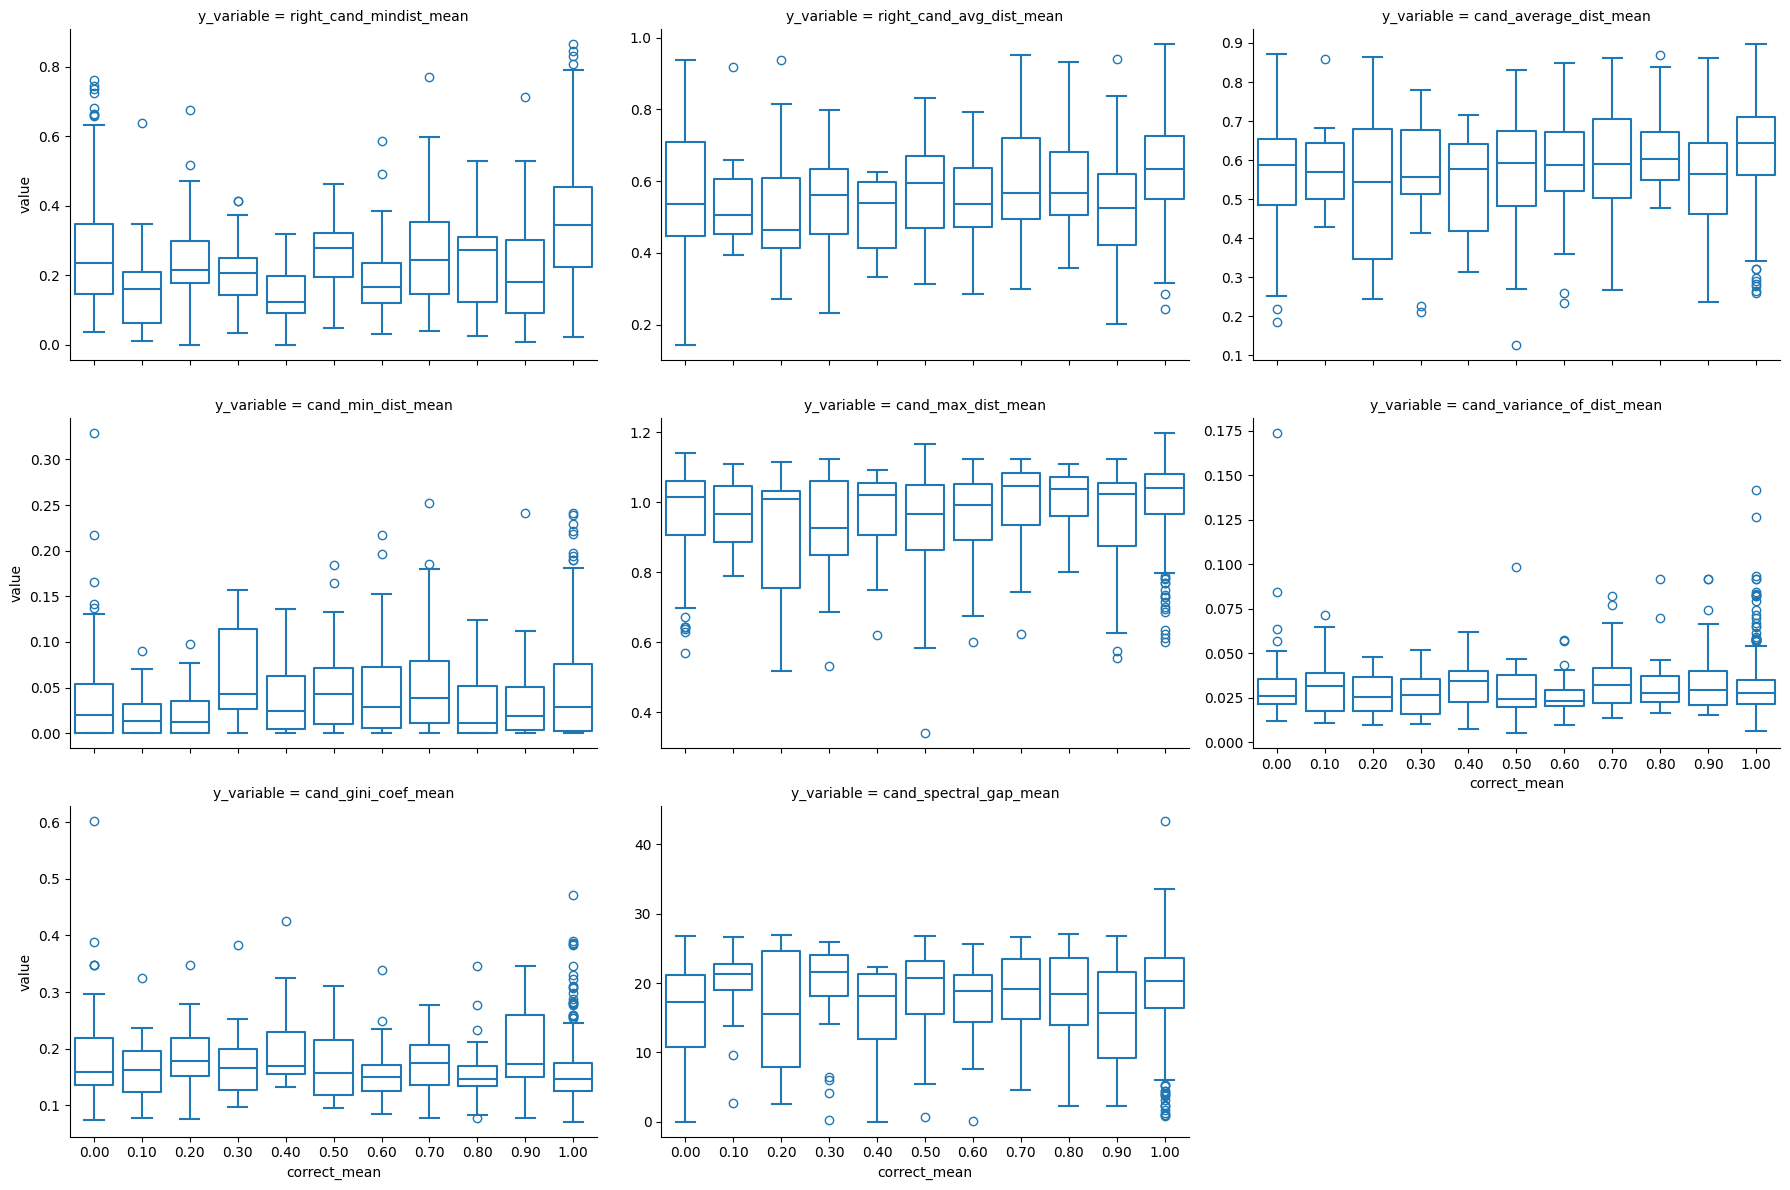

In [98]:

y_vars = ['right_cand_mindist_mean', 
          'right_cand_avg_dist_mean', 
          'cand_average_dist_mean',
          'cand_min_dist_mean',
          'cand_max_dist_mean',
          'cand_variance_of_dist_mean',
          'cand_gini_coef_mean',
          'cand_spectral_gap_mean']


# Reshape DataFrame to long format using `melt`
aggro_melted = aggro.melt(id_vars=["correct_mean"], value_vars=y_vars, 
                          var_name="y_variable", value_name="value")


# Create FacetGrid for multiple y-variables
g = sns.FacetGrid(aggro_melted, col="y_variable", height=4, aspect=1.5, 
                  sharex=True, sharey=False, col_wrap=3)

# Map plot to each facet
# g.map_dataframe(sns.violinplot, x="correct_mean", y="value", split=True, fill=False, inner="quart")
g.map_dataframe(sns.boxplot, x="correct_mean", y="value", fill=False)

for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.2f}"))
    ax.set_xticklabels([f"{tick:.2f}" for tick in sorted(aggro_melted["correct_mean"].unique())])

<Axes: >

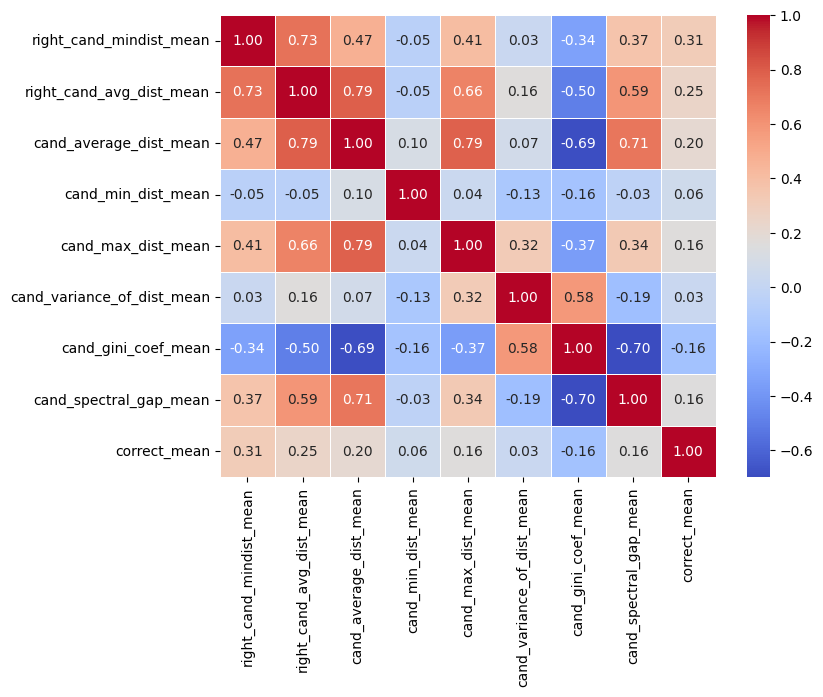

In [99]:
corr_matrix = aggro[['right_cand_mindist_mean', 
                     'right_cand_avg_dist_mean', 
                     'cand_average_dist_mean',
                     'cand_min_dist_mean',
                     'cand_max_dist_mean',
                     'cand_variance_of_dist_mean',
                     'cand_gini_coef_mean',
                     'cand_spectral_gap_mean',
                     'correct_mean']].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

<Axes: >

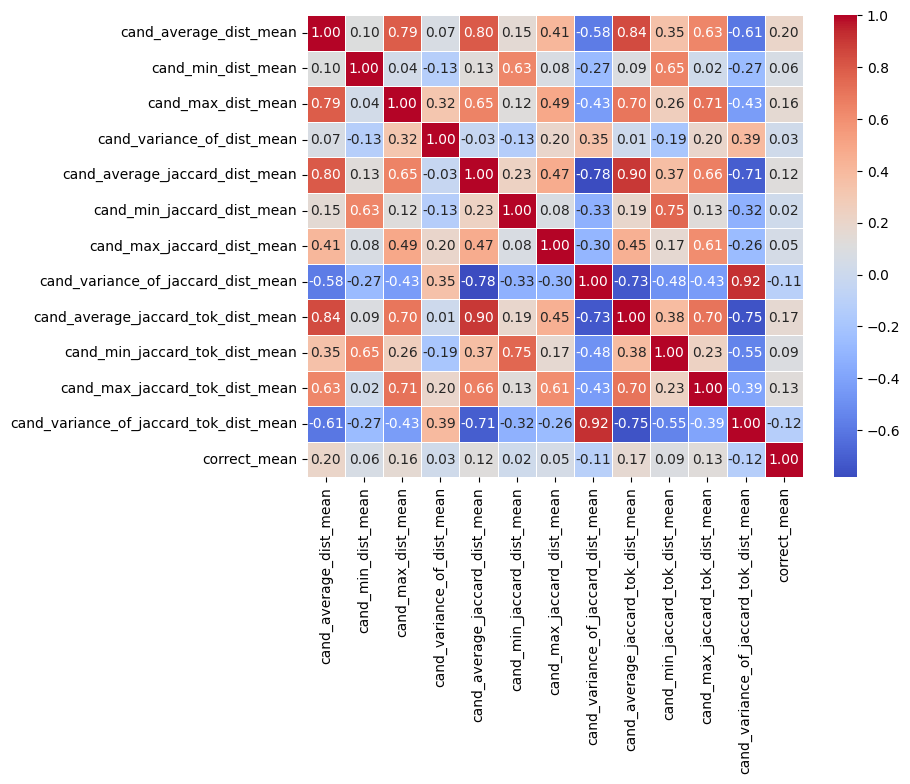

In [100]:
# distanze tra input (senza right candidate)

corr_matrix = aggro[['cand_average_dist_mean',
                     'cand_min_dist_mean',
                     'cand_max_dist_mean',
                     'cand_variance_of_dist_mean',
                     'cand_average_jaccard_dist_mean',
                     'cand_min_jaccard_dist_mean',
                     'cand_max_jaccard_dist_mean',
                     'cand_variance_of_jaccard_dist_mean',
                     'cand_average_jaccard_tok_dist_mean',
                     'cand_min_jaccard_tok_dist_mean',
                     'cand_max_jaccard_tok_dist_mean',
                     'cand_variance_of_jaccard_tok_dist_mean',
                     'correct_mean'
]].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

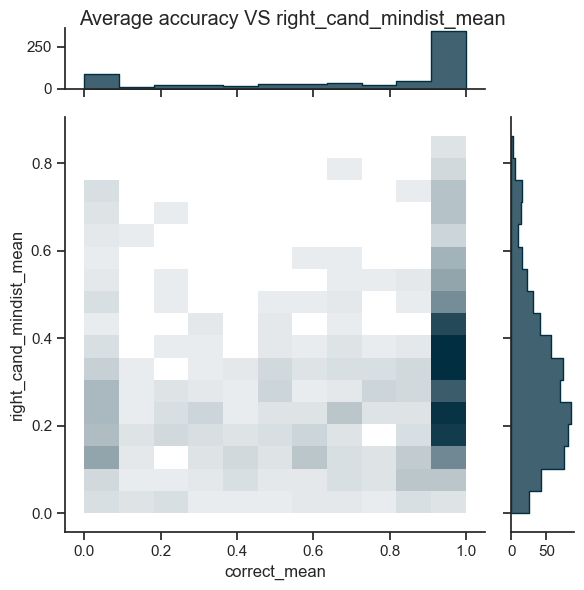

In [101]:
import seaborn as sns
sns.set_theme(style="ticks")

# most correlated
g = sns.JointGrid(data=aggro, x='correct_mean', y='right_cand_mindist_mean', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#012E40", cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#012E40")

g.fig.suptitle("Average accuracy VS right_cand_mindist_mean")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95) # Reduce plot to make room 

In [102]:
# aggregate answer text and embeddings per each prompt
ac = a.groupby('pid')['answer_clean'].apply(list).reset_index()
ace = a.groupby('pid')['answer_clean_embedding'].apply(list).apply(lambda x: np.vstack(x)).reset_index()

# anwer sequences
a['answer_seq0'] = a.answer_seq.str[0]
ace2 = a.groupby('pid')['answer_seq0'].apply(list).reset_index()

# candidates
ace3 = a.groupby('pid')['cand_clean'].apply(lambda x: list(x)[0]).reset_index()

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/1037979480.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['answer_seq0'] = a.answer_seq.str[0]


In [103]:
a.shape, ac.shape, ace.shape, ace2.shape

((6660, 39), (666, 2), (666, 2), (666, 2))

In [104]:
ac = ac.merge(ace, on='pid').merge(ace2, on='pid').merge(ace3, on='pid').merge(a[['pid', 'right_answer_clean_embedding']].drop_duplicates('pid'), on='pid', how='left')

In [105]:
%%time

# these depend on knowing the right answer

# extract cosine similarities among right candidate and all outputted  answers
from sentence_transformers.util import cos_sim
ac['cos_sim_right_and_answers'] = ac.apply(lambda x: cos_sim(x['right_answer_clean_embedding'], x['answer_clean_embedding']), axis=1)
ac['cos_sim_right_and_answers'] = ac.apply(lambda x: x['cos_sim_right_and_answers'].tolist()[0], axis=1)

# measures of consistency among output values
ac['right_and_answers_avg_dist'] = ac.apply(lambda x: 1. - (sum(x.cos_sim_right_and_answers) - 1.) / (len(x.cos_sim_right_and_answers) - 1), axis=1)
# distance from the nearest
ac['right_and_answers_mindist'] = ac.apply(lambda x: 1. - x.cos_sim_right_and_answers[np.argpartition(x.cos_sim_right_and_answers, -2)[-2]], axis=1) # second largest distance

CPU times: user 108 ms, sys: 1.3 ms, total: 110 ms
Wall time: 39.5 ms


In [106]:
%%time

# distance matrix stats
ac[['answers_average_dist', 'answers_min_dist','answers_max_dist','answers_variance_of_dist']] = ac.apply(lambda x: cosine_distance_stats(x.answer_clean_embedding), axis=1, result_type='expand') 

# gini coefficient
ac['answers_gini_coef'] = ac.apply(lambda x: gini_coefficient(x.answer_clean_embedding), axis=1) # gini coefficient

ac['answers_spectral_gap'] = ac.apply(lambda x: spectral_gap(x.answer_clean_embedding), axis=1) # spectral gap

# number of answers (set measure)
ac['num_answers'] = ac.apply(lambda x: len(set(x.answer_clean)), axis=1)

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:32: RuntimeWarning: divide by zero encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2k

CPU times: user 662 ms, sys: 6.42 ms, total: 669 ms
Wall time: 371 ms


/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:32: RuntimeWarning: divide by zero encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:32: RuntimeWarning: divide by zero encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_4429/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2

In [107]:
ac[['answers_average_jaccard_dist','answers_min_jaccard_dist','answers_max_jaccard_dist','answers_variance_of_jaccard_dist']] = ac.swifter.apply(lambda x: jaccard_distance_stats(x.answer_clean), axis=1, result_type='expand') 
ac[['answers_average_jaccard_tok_dist','answers_min_jaccard_tok_dist','answers_max_jaccard_tok_dist','answers_variance_of_jaccard_tok_dist']] = ac.swifter.apply(lambda x: jaccard_distance_stats(x.answer_seq0), axis=1, result_type='expand') 


Pandas Apply:   0%|          | 0/666 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/666 [00:00<?, ?it/s]

In [108]:
# entropy of answers
from scipy.stats import entropy
from collections import Counter

ac['answers_freqs'] = ac.apply(lambda x: list(Counter(x.answer_clean).values()), axis = 1)
ac['answers_entropy'] = ac.apply(lambda x: entropy(x.answers_freqs), axis = 1)
ac['answers_entropy_norm'] = ac.apply(lambda x: x.answers_entropy / max(1, np.log2(len(x.answers_freqs))), axis = 1)

In [109]:
(ac.answers_freqs.str.len() == ac.num_answers).sum() == ac.shape[0]

True

### progressive answers

In [133]:
# recover generated start token in seq
ac = ac.merge(segments[segments.segment=='generated'][['pid', 'start']].drop_duplicates(), on='pid', how='left')

In [146]:
len(ac.iloc[0].answer_seq0[:2])

2

In [319]:
# tokens
# 518 [
# 29962 ]
# 29966 <
# 29958 >
# 2 <\s>
# 2287 7187 24290 2725 DE SC RIPT ION
# 2287 7187 DE SC
# 11116 TYPE

myfilter = set([518, 29962, 29966, 29958, 2, 11116])

def remove_sublist(lst, sub):
    i = 0
    out = []
    while i < len(lst):
        if lst[i:i+len(sub)] == sub:
            i += len(sub)
        else:
            out.append(lst[i])
            i += 1
    return out

# remove template tokens
def cleanup_before_she_comes_sequence(myseq):
    myseq = remove_sublist(myseq, [2287, 7187, 24290, 2725])
    myseq = remove_sublist(myseq, [2287, 7187])
    myseq = [m for m in myseq if m not in myfilter]
    
    return myseq

def cleanup_before_she_comes_redux(mystr):
    mystr = mystr.replace('DESCRIPTION', '').replace('DESC', '').replace('TYPE', '').replace('[', '').replace(']', '')
    mystr = ' '.join(mystr.split())
    return mystr

In [339]:
%%time
ac['answer_seq0_clean'] = ac.apply(lambda x: [cleanup_before_she_comes_sequence(s[x.start:]) for s in x.answer_seq0], axis=1)

CPU times: user 129 ms, sys: 9.24 ms, total: 138 ms
Wall time: 137 ms


In [359]:
%%time

# for each max token, for each number of runs, extract answers entropy

runs = ac.answer_seq0.str.len().max()
MAXTOK = 14

mout = []

for tok in range(1, MAXTOK + 1):
    for run in range (2, runs + 1):
        print(tok, run, end='\r')
        for item in ac.itertuples():
            
            seqs = item.answer_seq0_clean[:run] # how many runs
            subs = [tokenizer.decode(s[:tok], skip_special_tokens=True) for s in seqs]
            subs_clean = subs # [cleanup_before_she_comes_redux(s) for s in subs]
            
            freqs = list(Counter(subs_clean).values())
            ent = entropy(freqs)
            ent_ = ent / max(1, np.log2(len(freqs)))
            
            mout.append((tok, run, item.pid, ent_))

CPU times: user 1min 8s, sys: 576 ms, total: 1min 8s
Wall time: 1min 8s


In [360]:
# all runs for reference

mout2 = []

for item in ac.itertuples():
            
    seqs = item.answer_seq0_clean
    subs = [tokenizer.decode(s, skip_special_tokens=True) for s in seqs]
    subs_clean = subs # [cleanup_before_she_comes_redux(s) for s in subs]
            
    freqs = list(Counter(subs_clean).values())
    ent = entropy(freqs)
    ent_ = ent / max(1, np.log2(len(freqs)))
            
    mout2.append((item.pid, ent_))

In [361]:
mou = pd.DataFrame(mout, columns=['tok', 'run', 'pid', 'ent'])
mou2 = pd.DataFrame(mout2, columns=['pid', 'ent_all'])

In [362]:
# correlation with answers_entropy_norm
mou = mou.merge(mou2, on='pid')
mou

,tok,run,pid,ent,ent_all
0,1,2,9,0.0,0.610304
1,1,3,9,0.0,0.610304
2,1,4,9,0.0,0.610304
3,1,5,9,0.0,0.610304
4,1,6,9,0.0,0.610304
...,...,...,...,...,...
83911,14,6,1797,0.0,0.000000
83912,14,7,1797,0.0,0.000000
83913,14,8,1797,0.0,0.000000
83914,14,9,1797,0.0,0.000000


In [363]:
mou2.describe()

,pid,ent_all
count,666.000000,666.000000
mean,899.698198,0.219021
std,520.529078,0.276980
min,9.000000,0.000000
25%,443.000000,0.000000
50%,883.000000,0.000000
75%,1370.250000,0.505891
max,1797.000000,0.693147


In [364]:
# debug

run = 7
tok = 10

item = ac[ac.pid==1797].iloc[0]

basetok = item.start
endtok = item.start + tok
            
seqs = item.answer_seq0[:run] # how many runs
subs = [tokenizer.decode(s[basetok:endtok], skip_special_tokens=True) for s in seqs]

subs_clean = [cleanup_before_she_comes_redux(s) for s in subs]
subs, subs_clean

(['<social liberalism [DESCRIPTION]',
  '<social liberalism [DESCRIPTION]',
  '<social liberalism [DESCRIPTION]',
  '<social liberalism [DESCRIPTION]',
  '<social liberalism [DESC] political ide',
  '<social liberalism [DESCRIPTION]',
  '<social liberalism [DESCRIPTION]'],
 ['<social liberalism',
  '<social liberalism',
  '<social liberalism',
  '<social liberalism',
  '<social liberalism political ide',
  '<social liberalism',
  '<social liberalism'])

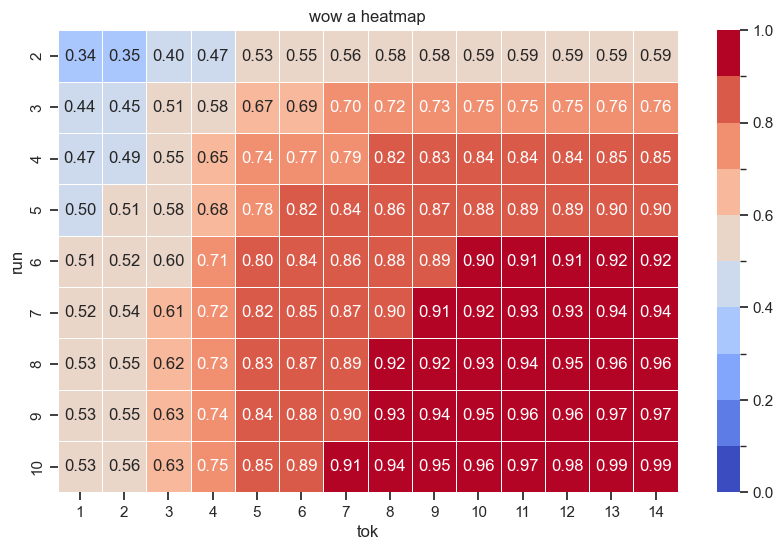

In [372]:
# how cutting at T tokens and R runs affect the entropy estimate

mycorr = mou.groupby(['tok', 'run'], as_index=False).ent.corr(mou.ent_all)

heatmap_data = mycorr.pivot(index="run", columns="tok", values="ent")

import matplotlib.colors as mcolors
bounds = np.arange(0., 1.1, 0.1)
norm = mcolors.BoundaryNorm(bounds, ncolors=256)

plt.figure(figsize=(10, 6))  # Adjust size as needed
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, norm=norm)

plt.title("wow a heatmap")
plt.xlabel("tok")
plt.ylabel("run")

plt.show()

### entailment

In [ ]:
aggrodue = ac.merge(aggro.reset_index(), on='pid', how='inner')

In [70]:
# s1 = "today is sunny and when it is sunny I am happy"
# s2 = "today I am happy"
# model.check_implication(s1, s2)
# candidates = p['question'].split(',. What')[0].split('<')[1:]
# candidates = [c.replace('>,', '').replace('>', '') for c in candidates]

In [71]:
DEVICE = "mps"

class BaseEntailment:
    def save_prediction_cache(self):
        pass


class EntailmentDeberta(BaseEntailment):
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v2-xlarge-mnli")
        self.model = AutoModelForSequenceClassification.from_pretrained(
            "microsoft/deberta-v2-xlarge-mnli").to(DEVICE)

    def check_implication(self, text1, text2, *args, **kwargs):
        inputs = self.tokenizer(text1, text2, return_tensors="pt").to(DEVICE)
        # The model checks if text1 -> text2, i.e. if text2 follows from text1.
        # check_implication('The weather is good', 'The weather is good and I like you') --> 1
        # check_implication('The weather is good and I like you', 'The weather is good') --> 2
        outputs = self.model(**inputs)
        logits = outputs.logits
        # Deberta-mnli returns `neutral` and `entailment` classes at indices 1 and 2.
        largest_index = torch.argmax(F.softmax(logits, dim=1))  # pylint: disable=no-member
        prediction = largest_index.cpu().item()
        # print('Deberta Input: %s -> %s', text1, text2)
        # print('Deberta Prediction: %s', prediction)

        return prediction


In [72]:
model = EntailmentDeberta()

In [73]:
# https://github.com/jlko/semantic_uncertainty/blob/master/semantic_uncertainty/uncertainty/uncertainty_measures/semantic_entropy.py#L169

def get_semantic_ids(strings_list, model, strict_entailment=False, example=None):
    """Group list of predictions into semantic meaning."""

    def are_equivalent(text1, text2):

        implication_1 = model.check_implication(text1, text2, example=example)
        implication_2 = model.check_implication(text2, text1, example=example)  # pylint: disable=arguments-out-of-order
        assert (implication_1 in [0, 1, 2]) and (implication_2 in [0, 1, 2])

        if strict_entailment:
            semantically_equivalent = (implication_1 == 2) and (implication_2 == 2)

        else:
            implications = [implication_1, implication_2]
            # Check if none of the implications are 0 (contradiction) and not both of them are neutral.
            semantically_equivalent = (0 not in implications) and ([1, 1] != implications)

        return semantically_equivalent

    # Initialise all ids with -1.
    semantic_set_ids = [-1] * len(strings_list)
    # Keep track of current id.
    next_id = 0
    for i, string1 in enumerate(strings_list):
        # Check if string1 already has an id assigned.
        if semantic_set_ids[i] == -1:
            # If string1 has not been assigned an id, assign it next_id.
            semantic_set_ids[i] = next_id
            for j in range(i+1, len(strings_list)):

                # Search through all remaining strings. If they are equivalent to string1, assign them the same id.
                if are_equivalent(string1, strings_list[j]):
                    semantic_set_ids[j] = next_id
            next_id += 1

    assert -1 not in semantic_set_ids

    return semantic_set_ids

def cluster_assignment_entropy(semantic_ids):
    """Estimate semantic uncertainty from how often different clusters get assigned.

    We estimate the categorical distribution over cluster assignments from the
    semantic ids. The uncertainty is then given by the entropy of that
    distribution. This estimate does not use token likelihoods, it relies soley
    on the cluster assignments. If probability mass is spread of between many
    clusters, entropy is larger. If probability mass is concentrated on a few
    clusters, entropy is small.

    Input:
        semantic_ids: List of semantic ids, e.g. [0, 1, 2, 1].
    Output:
        cluster_entropy: Entropy, e.g. (-p log p).sum() for p = [1/4, 2/4, 1/4].
    """

    n_generations = len(semantic_ids)
    counts = np.bincount(semantic_ids)
    probabilities = counts/n_generations
    assert np.isclose(probabilities.sum(), 1)
    entropy = - (probabilities * np.log(probabilities)).sum()
    return entropy

def semid_and_clustent(strings_list):
    semantic_ids = get_semantic_ids(strings_list, model)
    cae = cluster_assignment_entropy(semantic_ids)
    return (semantic_ids, cae)

In [74]:
%%time

aggrodue[['answer_semantic_ids', 'answer_cluster_assignment_entropy']] = aggrodue.swifter.apply(lambda x: semid_and_clustent(x.answer_clean), axis=1, result_type='expand') 

Pandas Apply:   0%|          | 0/666 [00:00<?, ?it/s]

CPU times: user 18min 9s, sys: 2min 45s, total: 20min 55s
Wall time: 20min 57s


In [75]:
# TODO: log-likelihood of generated tokens

In [76]:
%%time
# TODO: skipped for now - 90s per record
# aggrodue[['cand_semantic_ids', 'cand_cluster_assignment_entropy']] = aggrodue.apply(lambda x: semid_and_clustent(x.cand_clean), axis=1, result_type='expand') 

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.81 µs


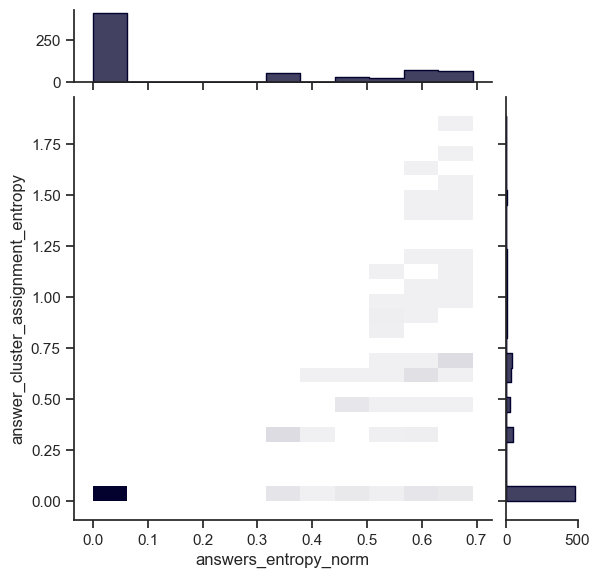

In [78]:
import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, x='answers_entropy_norm', y='answer_cluster_assignment_entropy', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.8, cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#03012d")

In [79]:
if False:
    with open('aggrodue.pickle', 'wb') as handle:
        pickle.dump(aggrodue, handle, protocol=pickle.HIGHEST_PROTOCOL)

### analysis

In [21]:
with open('aggrodue.pickle', 'rb') as handle:
    aggrodue = pickle.load(handle)

In [22]:
aggrodue

,pid,answer_clean,answer_clean_embedding,answer_seq0,cand_clean,right_answer_clean_embedding,cos_sim_right_and_answers,right_and_answers_avg_dist,right_and_answers_mindist,answers_average_dist,answers_min_dist,answers_max_dist,answers_variance_of_dist,answers_gini_coef,answers_spectral_gap,num_answers,answers_average_jaccard_dist,answers_min_jaccard_dist,answers_max_jaccard_dist,answers_variance_of_jaccard_dist,answers_average_jaccard_tok_dist,answers_min_jaccard_tok_dist,answers_max_jaccard_tok_dist,answers_variance_of_jaccard_tok_dist,answers_freqs,answers_entropy,answers_entropy_norm,correct_mean,right_cand_avg_dist_mean,right_cand_avg_dist_std,right_cand_mindist_mean,right_cand_mindist_std,cand_variance_of_dist_mean,cand_variance_of_dist_std,cand_gini_coef_mean,cand_gini_coef_std,cand_spectral_gap_mean,cand_spectral_gap_std,cand_average_dist_mean,cand_average_dist_std,cand_min_dist_mean,cand_min_dist_std,cand_max_dist_mean,cand_max_dist_std,cand_average_jaccard_dist_mean,cand_average_jaccard_dist_std,cand_min_jaccard_dist_mean,cand_min_jaccard_dist_std,cand_max_jaccard_dist_mean,cand_max_jaccard_dist_std,cand_variance_of_jaccard_dist_mean,cand_variance_of_jaccard_dist_std,cand_average_jaccard_tok_dist_mean,cand_average_jaccard_tok_dist_std,cand_min_jaccard_tok_dist_mean,cand_min_jaccard_tok_dist_std,cand_max_jaccard_tok_dist_mean,cand_max_jaccard_tok_dist_std,cand_variance_of_jaccard_tok_dist_mean,cand_variance_of_jaccard_tok_dist_std,answer_semantic_ids,answer_cluster_assignment_entropy
0,9,"[hyde county county in south dakota, united states county of south dakota, hyde county county in south dakota, united states...","[[0.047939774, 0.034902614, 0.034997083, 0.054616787, 0.026356021, -0.05846415, 0.017087627, -0.027931854, -0.04688239, 0.00...","[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...","[mister hyde supervillain from marvel comics comics character, hyde 2014 novel by david lozano garbala literary work, hyde e...","[[0.047939774, 0.034902614, 0.034997083, 0.054616787, 0.026356021, -0.05846415, 0.017087627, -0.027931854, -0.04688239, 0.00...","[1.0, 1.0, 1.0, 0.41776320338249207, 0.6144283413887024, 1.0]",1.935617e-01,0.000000e+00,0.289117,0.0,0.582237,0.060903,0.460465,1.122019e-01,3,0.499091,0.0,0.916667,0.170720,0.000000,0.0,0.000000,0.000000e+00,"[4, 1, 1]",0.867563,0.547371,0.666667,0.713225,0.0,0.321928,0.0,0.035219,0.0,0.156668,0.0,15.491575,0.0,0.676472,0.0,0.000000,0.0,1.141147,0.0,0.920567,0.0,0.000000,0.0,1.0,0.0,0.008887,0.0,0.861242,0.0,0.000000,0.0,0.978261,0.0,0.010161,0.0,"[0, 0, 0, 0, 1, 0]",0.450561
1,10,"[lyman unorganized territory unorganized territory, lyman unorganized territory unorganized territory, lyman unorganized ter...","[[0.04206834, 0.008647481, -0.00058775203, 0.017363606, -0.031490263, 0.011086458, -0.00013547765, -0.00535089, -0.05223565,...","[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...","[lyman railway station railway station in lyman, ukraine railway station, liman village in zmiiv raion, kharkiv oblast, ukra...","[[0.07589266, -0.030686643, 0.01414035, 0.07569041, 0.029559098, -0.030835535, -0.012345632, -0.03872519, -0.06244964, -0.02...","[0.4138926863670349, 0.4138926863670349, 0.4138926863670349, 0.4138926863670349, 0.4138926863670349, 0.4138926863670349]",7.033288e-01,5.861073e-01,0.000000,0.0,0.000000,0.000000,NaN,NaN,1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,[6],0.000000,0.000000,0.000000,0.666140,0.0,0.220180,0.0,0.050328,0.0,0.184050,0.0,20.428154,0.0,0.680013,0.0,0.009238,0.0,1.073664,0.0,0.896134,0.0,0.100000,0.0,1.0,0.0,0.016191,0.0,0.852802,0.0,0.120000,0.0,0.975610,0.0,0.012754,0.0,"[0, 0, 0, 0, 0, 0]",-0.000000
2,12,"[kasetsart university university in bangkok, thailand autonomous university, kasetsart university university in bangkok, tha...","[[0.041692093, -0.057695992, -0.

<Axes: >

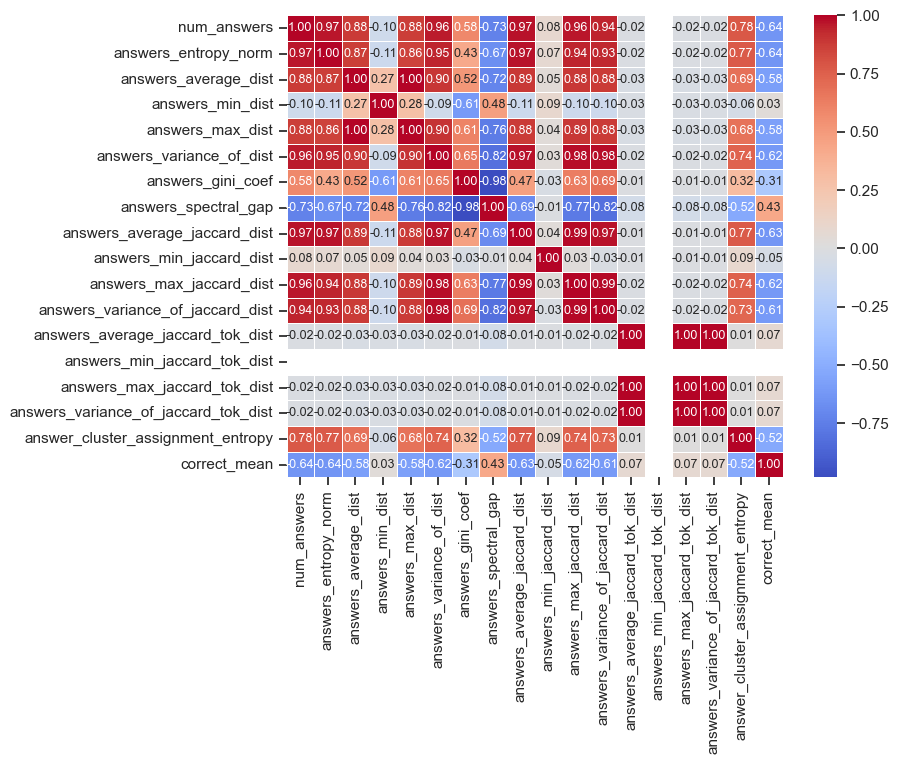

In [81]:
# correlazioni tra variabilità dell'output e accuracy

corr_matrix = aggrodue[['num_answers', 
                     'answers_entropy_norm', 
                     'answers_average_dist',
                     'answers_min_dist',
                     'answers_max_dist',
                     'answers_variance_of_dist',
                     'answers_gini_coef',
                     'answers_spectral_gap',
                     'answers_average_jaccard_dist',
                     'answers_min_jaccard_dist',
                     'answers_max_jaccard_dist',
                     'answers_variance_of_jaccard_dist',
                     'answers_average_jaccard_tok_dist',
                     'answers_min_jaccard_tok_dist',
                     'answers_max_jaccard_tok_dist',
                     'answers_variance_of_jaccard_tok_dist',
                     'answer_cluster_assignment_entropy',
                     'correct_mean']].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, annot_kws={"size": 9})

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_74642/3512050716.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{tick:.2f}" for tick in sorted(aggro_melted["correct_mean"].unique())])


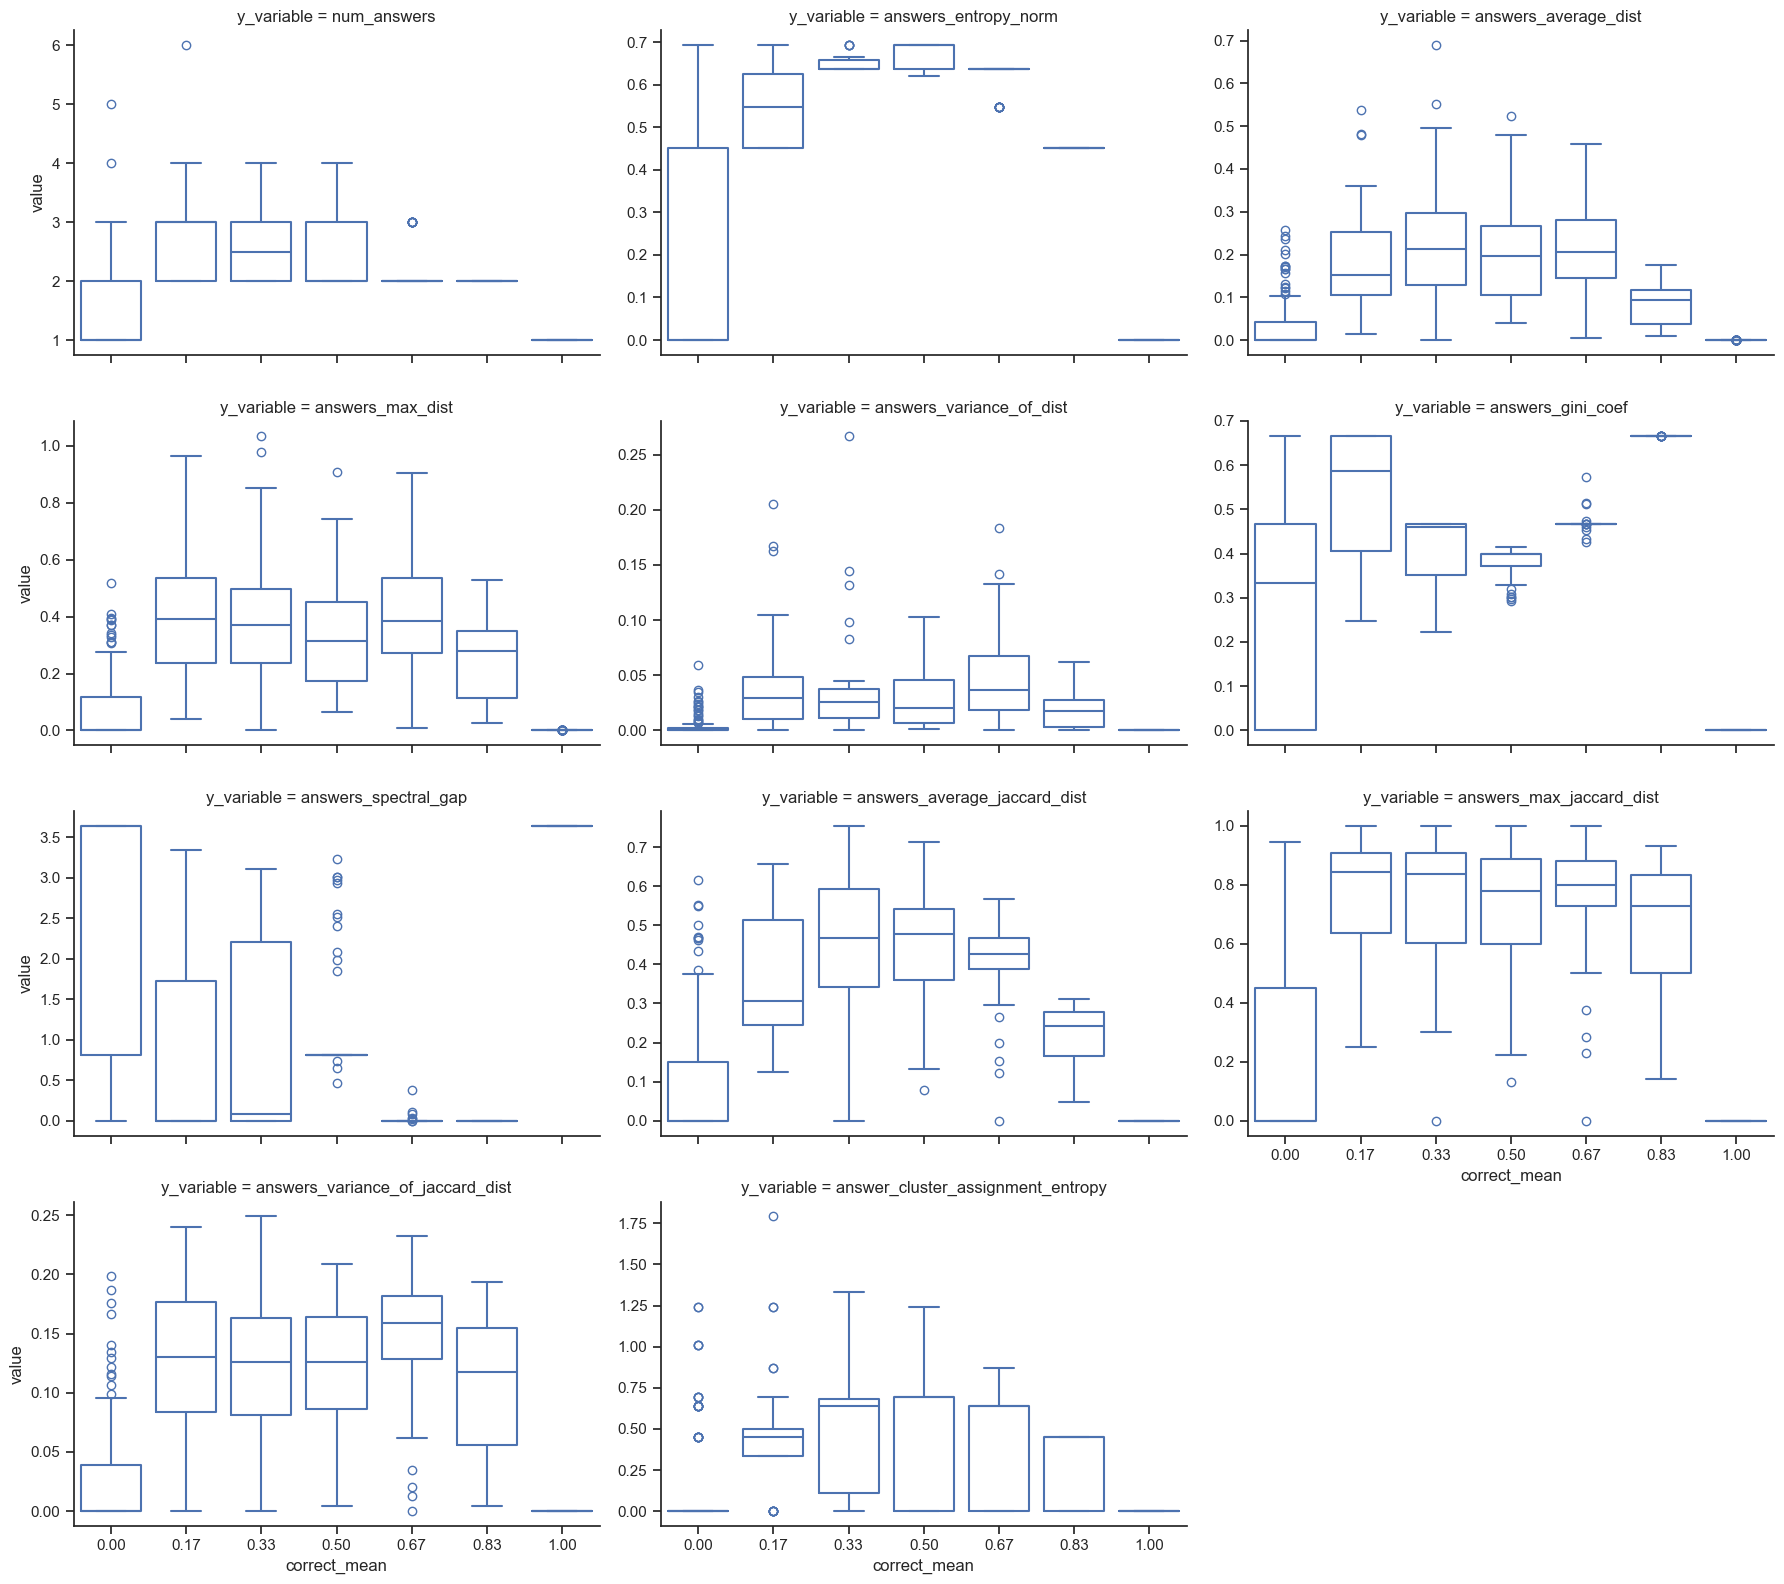

In [82]:

y_vars = ['num_answers', 
          'answers_entropy_norm', 
          'answers_average_dist', 
          'answers_max_dist',
          'answers_variance_of_dist',
          'answers_gini_coef',
          'answers_spectral_gap',
          'answers_average_jaccard_dist',
          'answers_max_jaccard_dist',
          'answers_variance_of_jaccard_dist',
          'answer_cluster_assignment_entropy']

# Reshape DataFrame to long format using `melt`
aggro_melted = aggrodue.melt(id_vars=["correct_mean"], value_vars=y_vars, 
                          var_name="y_variable", value_name="value")

# Create FacetGrid for multiple y-variables
g = sns.FacetGrid(aggro_melted, col="y_variable", height=4, aspect=1.5, sharex=True, sharey=False, col_wrap=3)

# Map violin plot to each facet
# g.map_dataframe(sns.violinplot, x="correct_mean", y="value", split=True, fill=False, inner="quart")
g.map_dataframe(sns.boxplot, x="correct_mean", y="value", fill=False)

for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.2f}"))
    ax.set_xticklabels([f"{tick:.2f}" for tick in sorted(aggro_melted["correct_mean"].unique())])

In [83]:
aggrodue.correct_mean.value_counts()

correct_mean
1.000000    364
0.000000     95
0.833333     53
0.666667     46
0.500000     46
0.333333     34
0.166667     28
Name: count, dtype: int64

In [84]:
# safety check
# aggrodue[(aggrodue.answers_entropy_norm<0.4) & (aggrodue.correct_mean<0.85) & (aggrodue.correct_mean>0.15)]

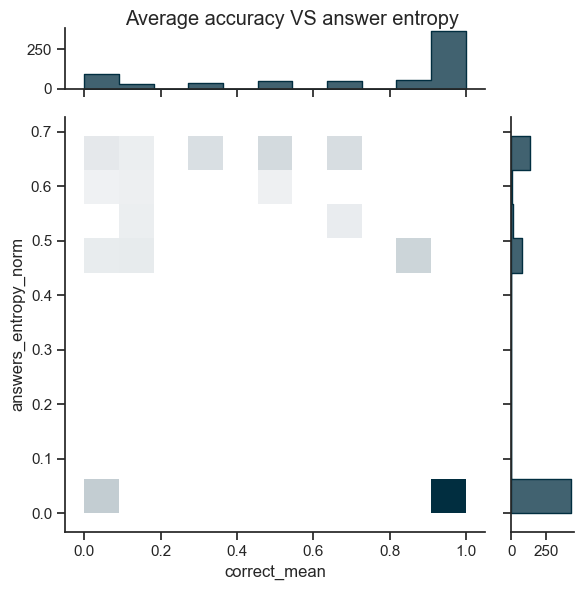

In [85]:
import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, x='correct_mean', y='answers_entropy_norm', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#012E40", cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#012E40")

g.fig.suptitle("Average accuracy VS answer entropy")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

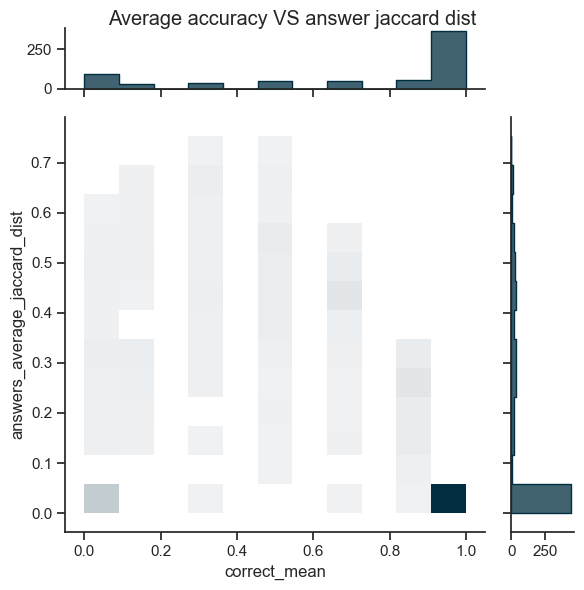

In [87]:
import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, x='correct_mean', y='answers_average_jaccard_dist', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#012E40", cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#012E40")

g.fig.suptitle("Average accuracy VS answer jaccard dist")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

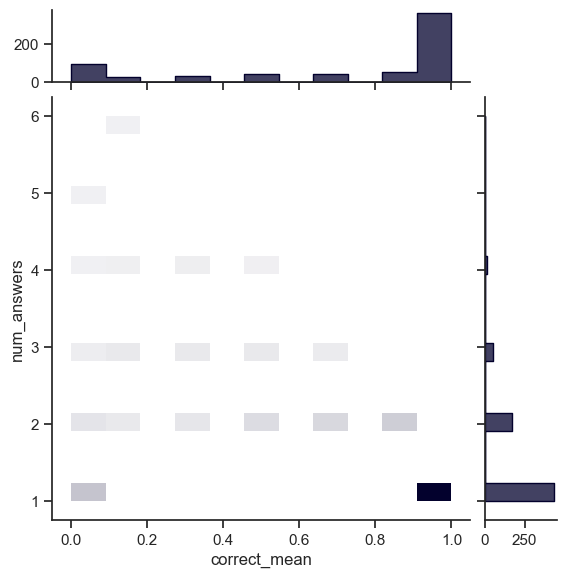

In [88]:
import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, x='correct_mean', y='num_answers', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.8, cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#03012d")

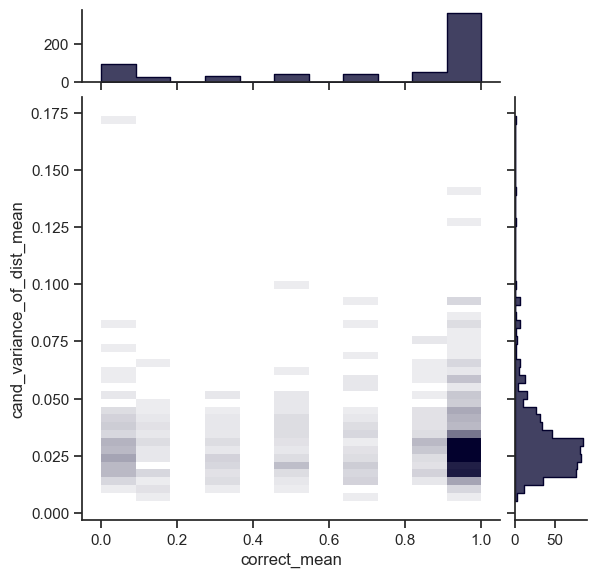

In [89]:

import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, y='cand_variance_of_dist_mean', x='correct_mean', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.8, cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#03012d")

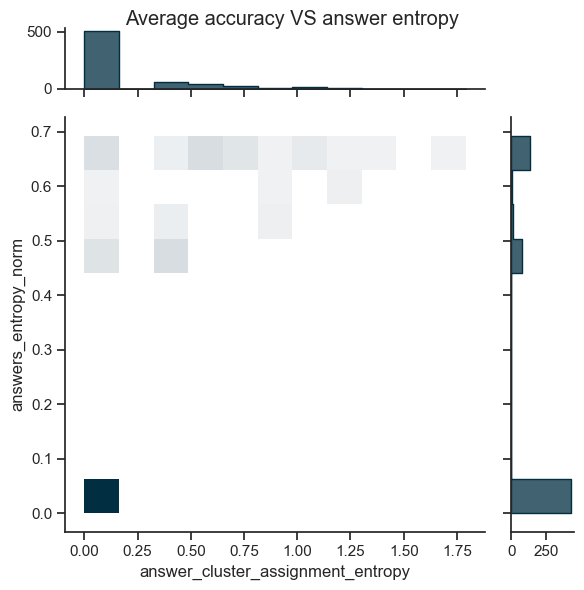

In [90]:
import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, x='answer_cluster_assignment_entropy', y='answers_entropy_norm', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#012E40", cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#012E40")

g.fig.suptitle("Average accuracy VS answer entropy")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)